In [2]:
# Loading packages
import pandas as pd
import numpy as np
import random
from plotnine import *
from scipy.stats import norm
# Percent format used for formatting the axes in the plots
from mizani.formatters import percent_format

First we can set the initial parameters of our model based on the provided data.

In [3]:
# Sample size from the problem
samp_size = 116
# Assumed proportion for a digit under the null
p_null = 0.1
# Calculate the standard error given this proportion
se_null = np.sqrt(p_null * (1-p_null)/samp_size)
# Set our significance level, which should equal the Type I error rate
alpha95 = 0.05 
alpha99 = 0.01 
# Calculate the relevant critical value given our alpha threshold
z_crit95 = norm.ppf(1-alpha95/2)
z_crit99 = norm.ppf(1-alpha99/2)

In [4]:
# Save down information about the observed frequency of the digit 7
p7_observed = 20/116

Next we can run a simulation analysis to see what our Type I error rate appears to be using the test procedure you were given in the problem set.

In [5]:
# Set up our number of simulations to run, 1,000 should give us a good approximation
n_sim = 10**5

# Create initial objects to store the observed maximum difference from 10% and the reject / accept decision
diff_holder = []
reject95_holder = []
reject99_holder = []

# Run the simulation
for i in range(n_sim):
    # Draw a random set of 116 digits
    samp_loop = np.array(random.choices(range(0,10), k=samp_size))
    
    # Calculate the proportion for each unique digit
    unique, counts = np.unique(samp_loop, return_counts=True)
    
    # Calculate the maximum deviation and conduct the hypothesis test
    max_diff_abs = np.abs(counts/samp_size - p_null).max()
    z_stat_loop = max_diff_abs/se_null

    # Calculate and store the largest maximum deviation
    diff_holder.append(max(counts/samp_size - p_null, key=abs))

    # Record if we reject the null at 95%
    if z_stat_loop >= z_crit95:
        reject95_holder.append(1)    
    else:
        reject95_holder.append(0)
    
    # Record if we reject the null at 99%
    if z_stat_loop >= z_crit99:
        reject99_holder.append(1)    
    else:
        reject99_holder.append(0)

In [6]:
# Calculate the simulated Type I error rate for alpha=5%
np.mean(reject95_holder)

0.46291

In [7]:
# Calculate the simulated Type I error rate for alpha=1%
np.mean(reject99_holder)

0.12606

In [8]:
# Within our process, what percent of samples produced more extreme values?
(np.abs(diff_holder) > np.abs(p7_observed - p_null)).mean()

0.07305

array([[<Axes: title={'center': 'max_diff'}>]], dtype=object)

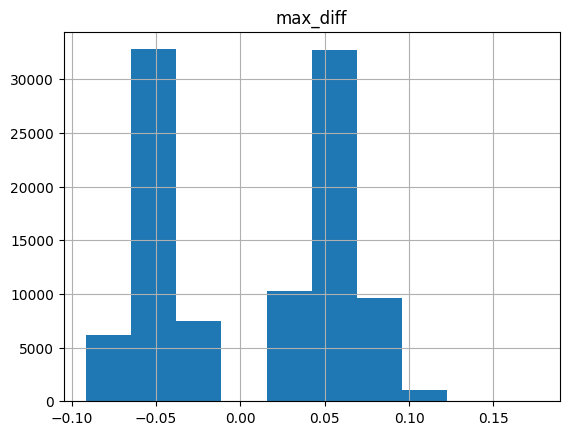

In [9]:
# Create a basic histogram of the sampling distribution of our largest deviations
d_plot = pd.DataFrame(
    {'max_diff': diff_holder}
)
d_plot.hist()

c:\Users\KEARNEY2\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
c:\Users\KEARNEY2\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: true_samp.png


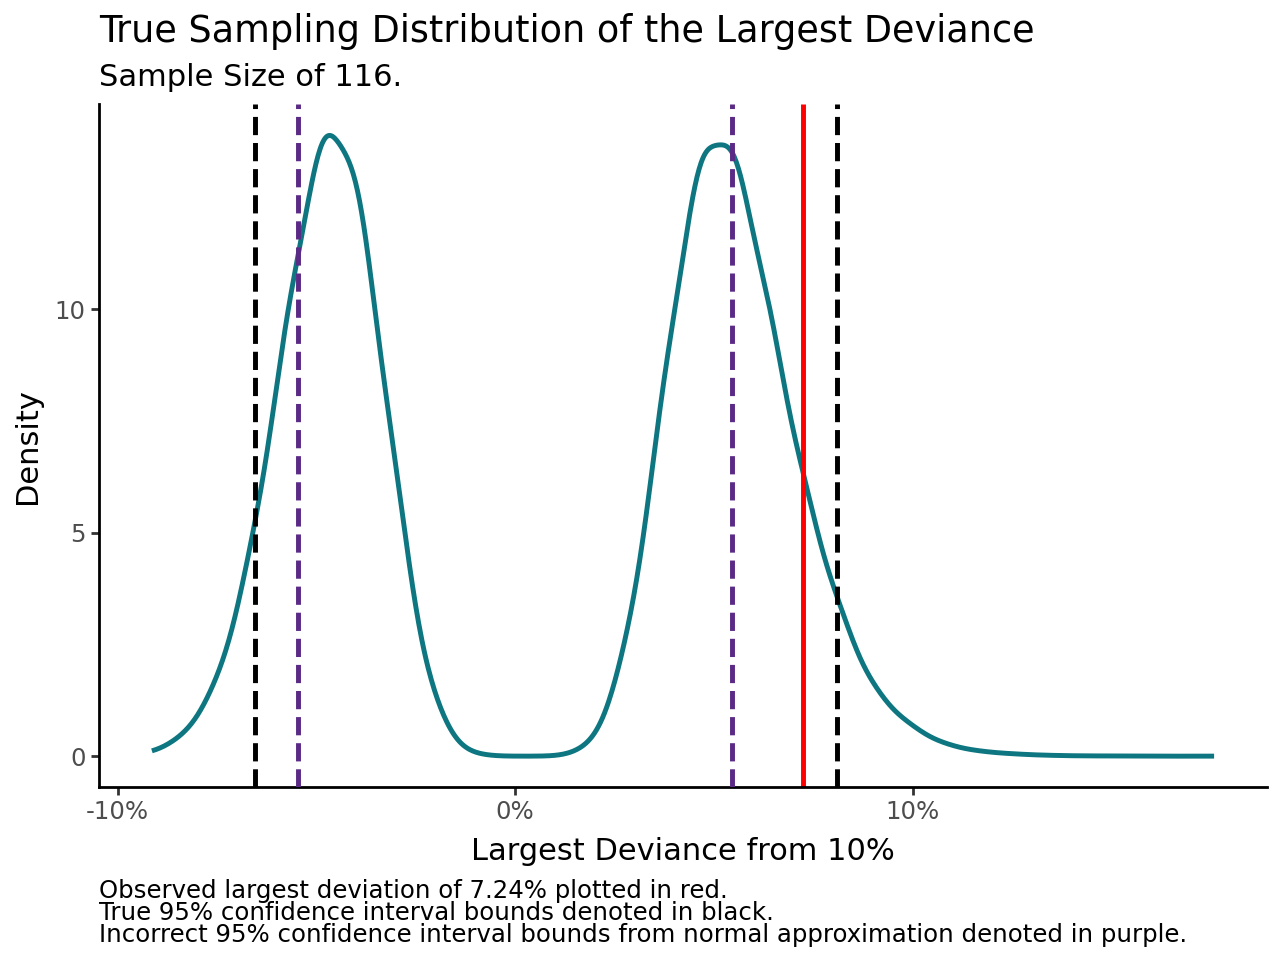

In [10]:
# And a more nicely formatted plot:
true_samp_dist = (
    ggplot(d_plot) + 
    # geom_histogram(aes(x='max_diff', y=stat(density))) +
    geom_density(aes(x='max_diff'), color='#0d7680', size=1) +
    geom_vline(xintercept=p7_observed-0.1, color='red', size=1) +
    geom_vline(xintercept=np.percentile(diff_holder, q=[2.5, 97.5]), color='black', size=1, linetype='dashed') +
    # Adding the incorrect bounds used in the test
    geom_vline(xintercept=[-z_crit95*se_null, +z_crit95*se_null], color='#5b2a86', size=1, linetype='dashed') +
    theme_classic() +
    # Use percent_format() for labels from the mizani package imported above
    scale_x_continuous(labels=percent_format()) +
    labs(
        x='Largest Deviance from 10%',
        y='Density',
        title='True Sampling Distribution of the Largest Deviance',
        subtitle=f'Sample Size of {samp_size}.',
        caption=f'Observed largest deviation of {(p7_observed - 0.1):.2%} plotted in red.\nTrue 95% confidence interval bounds denoted in black.\nIncorrect 95% confidence interval bounds from normal approximation denoted in purple.'
    ) +
    theme(
        plot_caption=element_text(ha='left')
    )   
)
ggsave(true_samp_dist, 'true_samp.png', height=4, width=8, dpi=1000)
true_samp_dist

The issue is we used a normal distribution as the approximate distribution for our test. But the true sampling distribution is not normal!

In [11]:
# Generate some normal data to plot with
x = np.linspace(-0.1, 0.1, 10**3)
y = norm.pdf(x, loc=p_null-0.1, scale=se_null)

c:\Users\KEARNEY2\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
c:\Users\KEARNEY2\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: norm_approx.png


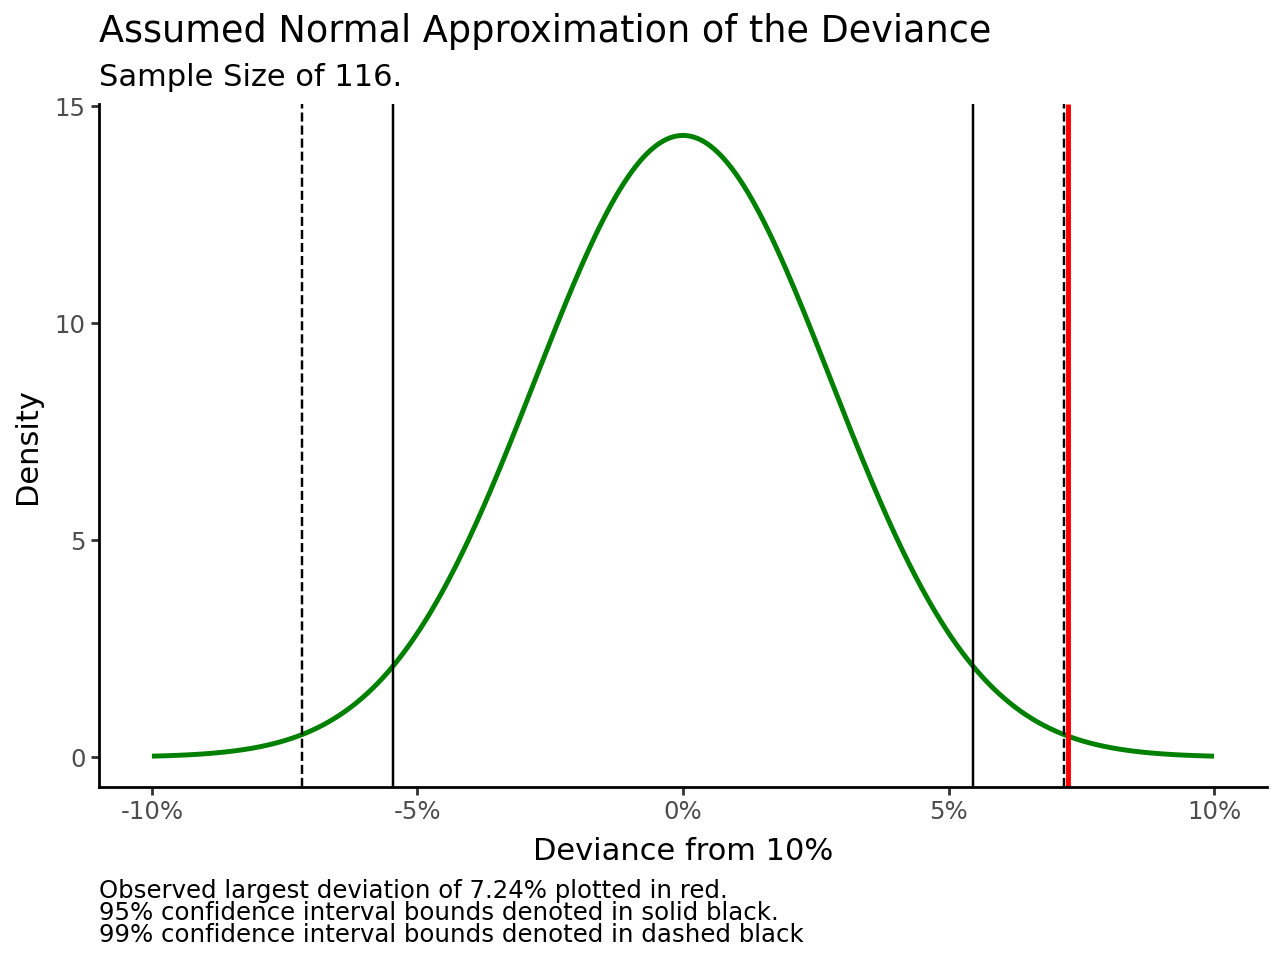

In [12]:
plot_normal = (
    ggplot() +
    geom_line(aes(x, y), color='green', size=1) +
    theme_classic() +
    scale_x_continuous(labels=percent_format()) +
    geom_vline(xintercept=p7_observed-0.1, color='red', size=1) +
    geom_vline(xintercept=norm.ppf(q=[0.025, 0.975], loc=p_null-0.1, scale=se_null), color='black') +
    geom_vline(xintercept=norm.ppf(q=[0.005, 0.995], loc=p_null-0.1, scale=se_null), color='black', linetype='dashed') +
    labs(
        x='Deviance from 10%',
        y='Density',
        title='Assumed Normal Approximation of the Deviance',
        subtitle=f'Sample Size of {samp_size}.',
        caption=f'Observed largest deviation of {(p7_observed - 0.1):.2%} plotted in red.\n95% confidence interval bounds denoted in solid black.\n99% confidence interval bounds denoted in dashed black'
    ) +
    theme(
        plot_caption=element_text(ha='left')
    )    
)
ggsave(plot_normal, 'norm_approx.png', height=4, width=8, dpi=1000)
plot_normal

# Chi-Square Test

A separate test exists to test all of the digits simultaneously. The Chi-squared test statistic can be calculated by summing up the deviations from the expected __count__ of observations for each category $i$ as:

$$\chi^2_{obs} = \sum_i \frac{\left(\textrm{observed count}_i - \textrm{expected count}_i\right)^2}{\textrm{expected count}_i}$$

In [13]:
# Save the observed vector of digit counts
observed_digits = np.array([11, 8, 9, 10, 5, 14, 20, 17, 13, 9])

In [14]:
# Construct the test statistic
chi_sq_test_stat = np.sum((observed_digits-observed_digits.sum()*p_null)**2/(observed_digits.sum()*p_null))

In [15]:
print(chi_sq_test_stat)

15.551724137931032


In [16]:
# Calculate the probability of this test statistic under the null
from scipy.stats import chi2
from scipy.stats import chisquare

In [17]:
1-chi2.cdf(chi_sq_test_stat, df=9)

0.07685369980326162

In [18]:
# chisquare function from scipy.stats package
observed_digits = np.array([11, 8, 9, 10, 5, 14, 20, 17, 13, 9])
chisquare(f_obs = observed_digits)

Power_divergenceResult(statistic=15.551724137931034, pvalue=0.07685369980326165)

In [19]:
# Plotting the distribution of the chi-square statistic and our sample
x_chisq = np.linspace(0, 30, 10**3)
y_chisq = chi2.pdf(x_chisq, df=9)

c:\Users\KEARNEY2\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:606: PlotnineWarning: Saving 8 x 4 in image.
c:\Users\KEARNEY2\AppData\Local\Programs\Python\Python312\Lib\site-packages\plotnine\ggplot.py:607: PlotnineWarning: Filename: chi_sq.png


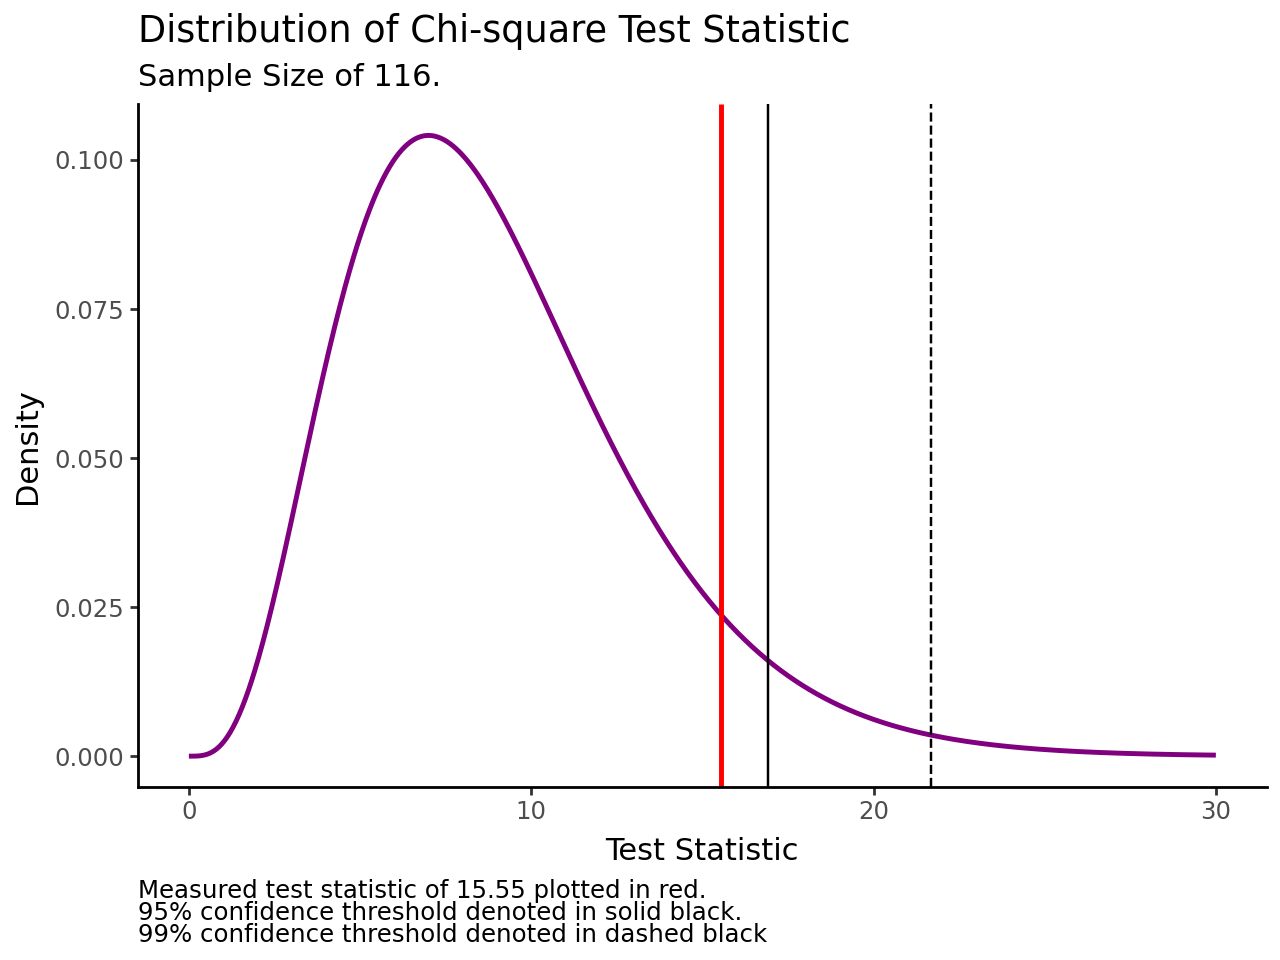

In [20]:
# Creating the plot
plot_chisq = (
    ggplot() +
    geom_line(aes(x_chisq, y_chisq), color='purple', size=1) +
    theme_classic() +
    # scale_x_continuous(labels=percent_format()) +
    geom_vline(xintercept=chi_sq_test_stat, color='red', size=1) +
    geom_vline(xintercept=chi2.ppf(0.95, df=9), color='black') +
    geom_vline(xintercept=chi2.ppf(0.99, df=9), color='black', linetype='dashed') +
    # geom_hline(yintercept=0, color='black') +
    labs(
        x='Test Statistic',
        y='Density',
        title='Distribution of Chi-square Test Statistic',
        subtitle=f'Sample Size of {samp_size}.',
        caption=f'Measured test statistic of {round(chi_sq_test_stat, ndigits=2)} plotted in red.\n95% confidence threshold denoted in solid black.\n99% confidence threshold denoted in dashed black'
    ) +
    theme(
        plot_caption=element_text(ha='left')
    )    
)
ggsave(plot_chisq, 'chi_sq.png', height=4, width=8, dpi=1000)
plot_chisq